In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize,stats
import seaborn as sns
from matplotlib.ticker import MultipleLocator
url='https://raw.githubusercontent.com/rossetl/Earthquake-Data-Analysis/main/SouthCalifornia-1982-2011_Physics-of-Data.dat'
labels=['#', 'pointer','t', 'mag', 'lat', 'long', 'dep']
df=pd.read_csv(url,sep="\s",names=labels,engine='python') 
df=df.drop(columns=['#'])
df=df.sort_values(by='t')
c=60*60*24

#------------Back Tree Algorithm---------------
def bta(mth):
    mth=4 #questa soglia selezione quale evento viene considerato importante (che verrà usato nel foreshock)
    mask=(df['mag']>=mth) & (df['pointer']!=-1)
    i1 = df['pointer'][mask].to_numpy()
    origin=0
    originv=0
    nv=0
    for i in range(len(i1)):
        mask1=[]
        mask1=[i1[i]]
        n=0
        while mask1[-1]!=-1:
            i2=df['pointer'][mask1[-1]] 
            mask1.append(i2)
            n=n+1
        nv=np.insert(nv,-1,n) 
        origin=np.insert(origin,-1,mask1[-2])
        originv=np.insert(originv,-1,mask1[:-1])
    
    nv=np.delete(nv,-1)        #numero di step prima di arrivare all'evento generatore
    origin=np.delete(origin,-1)#indici di riferimento dell'evento generatore
    originv=np.unique(np.delete(originv,-1))#tutti gli indici (no doppioni) che portano a ritroso all'evento generatore
    return origin, originv

# $P_{m,R}(t)$ 

C:\Users\andre\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
<ipython-input-40-461464363f3d>:52: RuntimeWarning: invalid value encountered in greater
  yhb=counts[counts>0]
<ipython-input-40-461464363f3d>:56: RuntimeWarning: invalid value encountered in greater
  xF=xF[counts>0]


---Fit Parameters with Errors---
a=-1.89 +-0.10
b=-0.88 +-0.03
r=-0.9311


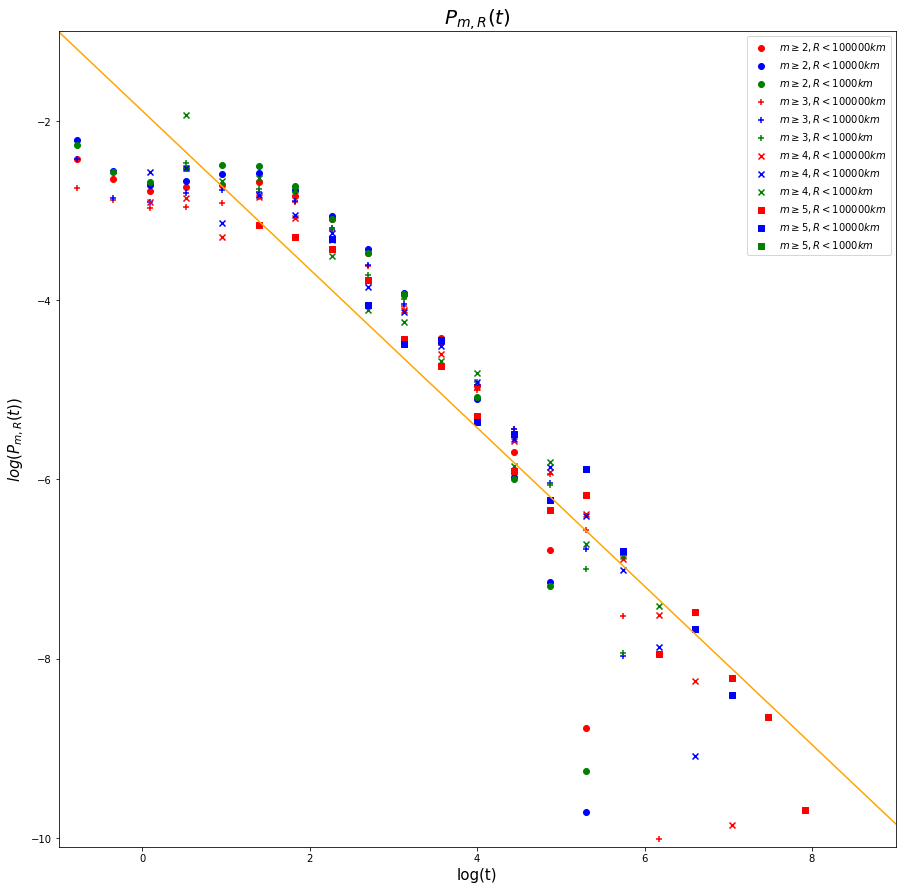

In [40]:
magth=np.arange(2,6,1)
extmv0=np.array([-4,-4,-4,-1])
extmv1=np.array([2,4,4,4])
ncpd=3 #number of class per decade
num_bins=(extmv1-extmv0)*(ncpd-1) 
R=np.matrix('100000 100000 100000 100000;10000 10000 10000 10000;1000 1000 1000 1000')
l=np.shape(R)[0]
colors=['red','blue','green']
markers=['o','+','x','s']

def p(i,j):
    if i==1 and j==0:
     p=2
    elif i==1 and j==1:
     p=3
    else:
     p=i+j
    return p
    
fig3, axu = plt.subplots(figsize=(15,15))
Yu=[]
Xu=[]
mu=[]
Ru=[]
dfu=[]
alphau=[]
Cu=[]

dfv=np.array([0.91,0.94,0.97,0.95])

#alpha=np.array([0.99,1.07,1.04,2.28]) #3°model
alpha=np.array([0.6,0.7,0.93,0.76]) #1°model     <-----
C=np.array([103,67,42,367])


for i in range(2):
    for j in range(2):
        for z in range(l):
            mask=(df['mag']>=magth[p(i,j)])
            dr=df[mask]
            dr=dr.drop(columns=['t','pointer','mag'])
            dr['dpw']=((dr.diff()**2).sum(axis=1))**0.5 #dpw stay  for distance pairs waise
            dr.insert(loc=0, column='t', value=df['t'][dr.index])
            dr.insert(loc=1, column='dt', value=df['t'][dr.index])
            dr['dt']=dr['dt'].diff()
            dr=dr.drop(dr.index[0])
            Tlim=0.0001 #40s as written in the paper
            dr=dr.drop(dr[dr['dt']<Tlim].index)
            dr=dr.drop(dr[dr['dpw'] > R[z,p(i,j)]].index)

            counts, bins, hbars =axu.hist(dr['dt'], visible=0,bins=np.logspace(-1,9,24),density=1) 
            yhb=counts[counts>0]
            yhb=yhb
            Yu=np.insert(Yu,0,yhb)
            xF=(bins[:-1]*bins[1:len(counts)+1])**0.5
            xF=xF[counts>0]
            Xu=np.insert(Xu,0,xF)
            dfu=np.insert(dfu,0,np.ones(len(xF))*dfv[p(i,j)])
            alphau=np.insert(alphau,0,np.ones(len(xF))*alpha[p(i,j)])
          #  Cu=np.insert(Cu,0,np.ones(len(xF))*C[p(i,j)])
            mu=np.insert(mu,0,np.ones(len(xF))*magth[p(i,j)])
            Ru=np.insert(Ru,0,np.ones(len(xF))*R[z,p(i,j)]*1000)
            
            axu.scatter(np.log10(xF),np.log10(yhb),label='$m\geq%s, R<%.0f km$'%(magth[p(i,j)],R[z,p(i,j)]),
                        color=colors[z],marker=markers[p(i,j)])
  
axu.set_title('$P_{m,R}(t)$',size=20)
axu.set_xlabel('log(t)',size=15)
axu.set_ylabel('$log(P_{m,R}(t))$',size=15)
axu.legend(loc='upper right');

def f(x,a,b):
    f=a+b*x
    return f

U=optimize.curve_fit(f,np.log10(Xu),np.log10(Yu),p0=[1,-1])  #poisson error is assumed ,sigma=Y**(-0.5)
res = stats.linregress(np.log10(Xu),np.log10(Yu))

xx=np.linspace(-1,9,100)
axu.plot(xx,f(xx,U[0][0],U[0][1]),'orange',label='fit')
axu.set_xlim(-1,9);
axu.set_ylim(-10.1,-1);

print('---Fit Parameters with Errors---')
print('a=%.2f'%U[0][0],'+-%.2f'%U[1][0,0]**0.5)
print('b=%.2f'%U[0][1],'+-%.2f'%U[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

Quando si computa Pm,R stiamo selezionando eventi sismici con una magnitudo oltre una certa soglia MA dentro una certa soglia di distanza. Si sono prima selezionati tutti gli eventi con m>mth e poi si è filtrato in base alla distanza. Questo vuol dire che in un qualche modo stiamo cercando la distribuzione dei tempi che si manifestino terremoti importanti ma che siano "vicini" entro una certa soglia. Se infatti aumentiamo R stiamo considerando la distribuzione dei tempi fra due terremoti importanti in qualsiasi punto della mappa, ma se restringiamo R vuol dire che in un qualche senso stiamo "forzando una causalità" fra i terremoti, siamo interessati alla PDF del tempo che dopo un terremoto importante se ne verifichi un altro, ugualmente importante, entro una certa distanza. Ovviamente ci stiamo riferendo a una distanza fra ipocentri, che può essere poi proiettata a epicentri, in modo che diventi fruibile per la popolazione. L'idea di evoluzione temporale è verificata dal grafico qui sotto.

# Origin-Main

In [ ]:
#------------MAIN-ORIGIN Magnitude-Study---------------
fig0, axs = plt.subplots(1,4,figsize=(12,4))
fig0.tight_layout(pad=3.0)

counts, bins, bars = axs[0].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),edgecolor='black',density=1)
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('PDF')
axs[0].set_title('$m$ @pointer=-1')

axs[1].step(bins[:-1],counts.cumsum()/np.sum(counts),color='red')
axs[1].set_xlabel('Magnitude')
axs[1].set_ylabel('CDF');

counts, bins, bars = axs[2].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),edgecolor='black',
                                 density='cumulative',cumulative=-1)
axs[2].set_yscale('log')
axs[2].set_xlabel('Magnitude')
axs[2].set_ylabel('Reverse CDF')

logmB=np.log10(counts[:-1])
xB=(bins[:-2]+bins[1:-1])/2
def f(x,a,b):
    f=a+b*x
    return f
B=optimize.curve_fit(f,xB,logmB,sigma=counts[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xB, logmB)

xx=np.linspace(2,7,100)
axs[3].plot(xx,f(xx,B[0][0],B[0][1]),'orange',label='fit')
axs[3].scatter(xB,logmB,label='data',linewidths=1,marker='.')
axs[3].set_xlabel('Magnitude',size=12)
axs[3].set_ylabel('$log_{10}(N_{counts})$',size=12)
axs[3].legend();

print('---Fit Parameters with Errors---')
print('a=%.2f'%B[0][0],'+-%.2f'%B[1][0,0]**0.5)
print('b=%.2f'%B[0][1],'+-%.2f'%B[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

mth=4
origin,originv=bta(mth)#we call the back tree-alg
mask=(df['mag']>=mth) & (df['pointer']!=-1)  
i1 = df['pointer'][mask].to_numpy()
dtmc=df['t'][mask].to_numpy()-df['t'][origin].to_numpy()
x1=(df['lat'][mask].to_numpy()-df['lat'][origin].to_numpy())**2
y1=(df['long'][mask].to_numpy()-df['long'][origin].to_numpy())**2
z1=(df['dep'][mask].to_numpy()-df['dep'][origin].to_numpy())**2
drmc=(x1+y1+z1)**0.5
dfr=pd.DataFrame({'dtmc': dtmc/c, 'drmc': drmc/1000,'mag':df['mag'][mask]})

#------------Time & Distance PDF ---------------

fig1, ax = plt.subplots(figsize=(15,15))
lev=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

sns.kdeplot(x=np.log10(dfr['dtmc']), y=np.log10(dfr['drmc']),fill='true',ax=ax,levels=lev);
ax.set_xlabel('Time Distance Origin-Main',size=12);
ax.set_ylabel('Spatial Distance Origin-Main',size=12);
ax.set_title('2D-PDF for Distance and Time $m\geq%.0f$ for Origin-Main Earthquake'%mth)
ax.set_xticks([-3.15,-1.38,0,0.85,1.48,2.56,3.56]) #-3.15 -> 1min  -- -4.93 -> 1sec
ax.set_xticklabels(['1min','1h','1d','1w','1mth','1y','10y']);
ax.set_yticks([-1,0,1,2,3,4])
ax.set_yticklabels(['100m','1km','10km','100km','1000km','10000km'])
ax.set_xlim(-5,4.5);
ax.set_ylim(-2,3);
ax.grid(which='both',b=1, linestyle='dashed')

mthf=6
mask1=(df['mag']<(mthf-1)) & (df['mag']>=(mthf-2)) 
ax.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),color='green',
           label=r'$%s\leq m<%s$'%(mthf-2,mthf-1),s=20);

mask1=(df['mag']<mthf) & (df['mag']>=(mthf-1)) 
ax.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),color='orange',
           label=r'$%s\leq m<%s$'%(mthf-1,mthf),s=40);

mask1=(df['mag']<(mthf+1)) & (df['mag']>=(mthf)) 
ax.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),color='red',
           label=r'$%s\leq m<%s$'%(mthf,mthf+1),s=60);

ax.scatter(np.log10(dfr['dtmc'][dfr['mag']>=(mthf+1)]),np.log10(dfr['drmc'][dfr['mag']>=(mthf+1)]),color='m',
          label='$m\geq%s$'%(mthf+1),s=80);
ax.legend();

Questo grafico mostra come i terremoti inidicizzati -1 (generatori) non sono quelli a maggiore terremoto (CDF plot utile se si usa il log-y space), nemmeno se considerassimo i segnali con m=2 come noise. Distribuzione di tipo lineare sull log-y space

# Foreshock

In [ ]:
#---We consider all the events happened before the main earthquake----

fig0, axs = plt.subplots(1,2,figsize=(12,4))
fig0.tight_layout(pad=3.0)

mth=4
origin,originv=bta(mth)  #we call the back tree-alg
db=pd.DataFrame({'mag': df['mag'][originv]}) #in origin stiamo consierando terremoti importanti con m>mth
mthu=2 #lower magnitude, we can adjust it (it's difficult to detect small eartquake)
db=db['mag'][db['mag']>mthu]
counts, bins, bars = axs[0].hist(db, bins=np.linspace(mthu,7,25-4),edgecolor='black',density=1,cumulative=-1)
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('Reverse CDF')

yhb=counts[counts>0]
logmF=np.log10(yhb)
xF=(bins[:-1]+bins[1:len(counts)+1])/2
xF=xF[counts>0]

def f(x,a,b,c):
    f=a+b*x+c*x**2
    return f
F=optimize.curve_fit(f,xF,logmF,sigma=counts[counts>0]**(-0.5),p0=[0.1,0.2,0])  #poisson error is assumed

def q(x,a,b):
    q=a+b*x
    return q
Q=optimize.curve_fit(q,xF,logmF,sigma=counts[counts>0]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xF, logmF)

xx=np.linspace(2,7,100)
axs[1].plot(xx,f(xx,F[0][0],F[0][1],F[0][2]),'orange',label='fit_3p')
axs[1].plot(xx,q(xx,Q[0][0],Q[0][1]),'red',label='fit_2p')
axs[1].scatter(xF,logmF,label='data',linewidths=1)
axs[1].set_xlabel('Magnitude',size=12)
axs[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
axs[1].set_title('Foreshock')
axs[1].legend();

print('---Fit Parameters with Errors 3P---')
print('a=%.2f'%F[0][0],'+-%.2f'%F[1][0,0]**0.5)
print('b=%.2f'%F[0][1],'+-%.2f'%F[1][1,1]**0.5)
print('c=%.2f'%F[0][2],'+-%.2f'%F[1][2,2]**0.5)
print('---Fit Parameters with Errors 2P---')
print('a=%.2f'%Q[0][0],'+-%.2f'%Q[1][0,0]**0.5)
print('b=%.2f'%Q[0][1],'+-%.2f'%Q[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

# Aftershock

In [ ]:
#----stiamo considerando tutti i terremoti dopo il main-----

mth=5 #questa è una magnitudo soglia per studiare l'after shock è indipendente dalle scelte precedenti
drf=df['mag'][df['mag']>=mth] 
i1=drf.index
n=0
for i in range(len(i1)):
    n=np.insert(n,-1,(df['pointer'][df['pointer']==i1[i]].index).to_numpy() )
n=np.delete(n,-1) #cerco tutti i terremoti che puntano ai terremoti scelti.

fig0, axs = plt.subplots(1,2,figsize=(12,4))
fig0.tight_layout(pad=3.0)

counts, bins, bars = axs[0].hist(df['mag'][n], bins=np.linspace(2,7,25-4),edgecolor='black',density=1,cumulative=-1)
axs[0].set_xlabel('Magnitude ')
axs[0].set_ylabel('Reverse CDF')

logmA=np.log10(counts[:-1])
xA=(bins[:-2]+bins[1:-1])/2

def f(x,a,b):
    f=a+b*x
    return f
A=optimize.curve_fit(f,xA,logmA,sigma=counts[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xA, logmA)

xx=np.linspace(2,7,100)
axs[1].set_xlabel('Magnitude',size=12)
axs[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
axs[1].plot(xx,f(xx,A[0][0],A[0][1]),'orange',label='fit')
axs[1].scatter(xA,logmA,label='data',linewidths=1,marker='.')
axs[1].set_title('AfterShock')
axs[1].legend();

print('---Fit Parameters with Errors---')
print('a=%.2f'%A[0][0],'+-%.2f'%A[1][0,0]**0.5)
print('b=%.2f'%A[0][1],'+-%.2f'%A[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

# Gutenberg–Richter Law 

---Fit Parameters with Errors---
a=2.09 +-0.02
b=-0.98 +-0.01
r=-0.9994


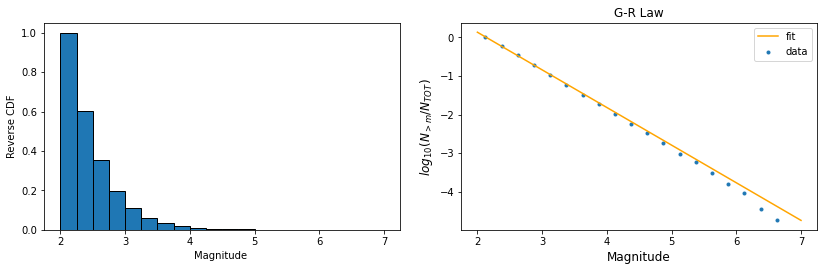

In [4]:
#-----qui stiamo considerando tutti i terremoti-----

fig0, axs = plt.subplots(1,2,figsize=(12,4))
fig0.tight_layout(pad=3.0)
def f(x,a,b):
    f=a+b*x
    return f
counts, bins, bars = axs[0].hist(df['mag'], bins=np.linspace(2,7,25-4),edgecolor='black',density=1,cumulative=-1)
axs[0].set_xlabel('Magnitude ')
axs[0].set_ylabel('Reverse CDF')

logmG=np.log10(counts[:-1])  
xG=(bins[:-2]+bins[1:-1])/2#poisson error is assume  
G=optimize.curve_fit(f,xG,logmG,sigma=counts[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
res = stats.linregress(xG, logmG)

xx=np.linspace(2,7,100)
axs[1].set_xlabel('Magnitude',size=12)
axs[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
axs[1].plot(xx,f(xx,G[0][0],G[0][1]),'orange',label='fit')
axs[1].scatter(xG,logmG,label='data',linewidths=1,marker='.')
axs[1].set_title('G-R Law')
axs[1].legend();
print('---Fit Parameters with Errors---')
print('a=%.2f'%G[0][0],'+-%.2f'%G[1][0,0]**0.5)
print('b=%.2f'%G[0][1],'+-%.2f'%G[1][1,1]**0.5)
print('r=%.4f'%res.rvalue)

# Universal Law (Part 1)

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Universal Law')
plt.xlabel('Magnitude',size=12)
plt.ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
plt.scatter(xA,logmA,label='Aftershock',linewidths=1,marker='.',color='blue')       #R-CDF terremoti figli dopo main vs m
plt.scatter(xB,logmB,label='Originshock',linewidths=1,marker='.',color='red')       #R-CDF origin vs m
plt.scatter(xF,logmF,label='Foreshock',linewidths=1,marker='.',color='green')       #R-CDF (tutti) terremoti prima main vs m
plt.scatter(xG,logmG,label='GR-Law',linewidths=1,marker='.',color='m')              #R-CDF tutti terremoti vs m

plt.legend();

Questa potrebbe essere una proposta di Legge Universale: i punti rossi sono riferiti alla magnitudo dei terremoti che sono etichettati con -1, ovvero sia che non sono originati da un precedente evento; i punti blu sono riferiti alla magnitudo dei terremoti (sciame) che sono avvenuti dopo la verifica di un terremoto importante (m>5); i punti in verde sono riferiti alla magnitudo di quei terremoti che intercedono tra un terremoto importante (m>5) e il suo evento originatore. In magenta la legge di GR (slope -0.98 simile a -0.95 riportato nel paper.)

1. AfterShock: considero solo gli eventi immediatamente collegati al Main
2. ForeShock: considero solo eventi prima del Main
3. Origin-Main: considero solo eventi originatori e i Main
4. GR: considero tutti i terremoti

# Universal Law (Part 2)

Servirà G(0,1) il coefficiente derivante da GU (OK) Servirà Xu,Yu i dati di Pm,R (OK) servirà alfa e i dati dalla legge di Omori (DA FARE) e la dimensione spettrale df (DA FARE)

In [ ]:
fig0, axt = plt.subplots(figsize=(15,15))

alfa=1
dsf=-1.4
b=1
const=10**-4
Yt2=Yu*Xu**alfa
Xt2=Xu*(10**(-b*mu))*Ru**(dsf)

alfa=1
dsf=-1.1
b=1
const=10**-4
Yt1=Yu*Xu**alfa
Xt1=Xu*(10**(-b*mu))*Ru**(dsf)

alfa=1
dsf=-0.9
const=10**-4
b=1
Yt3=Yu*Xu**alfa
Xt3=Xu*(10**(-b*mu))*Ru**(dsf)
#axt.set_xlim(0,10)
#axt.set_ylim(-16,-3)
#axt.scatter(np.log10(Xt),np.log10(Yt))
axt.scatter(np.log10(Xt1),np.log10(Yt1),color='red')
axt.scatter(np.log10(Xt2),np.log10(Yt2),color='blue')
axt.scatter(np.log10(Xt3),np.log10(Yt3),color='green')
axt.set_title('$P_{m,R}(t)$',size=20)
axt.set_xlabel('$log(tS^{-b}R^{d_{f}})$',size=15)
axt.set_ylabel('$log(t^{\\alpha}P_{m,R}(t))$',size=15);

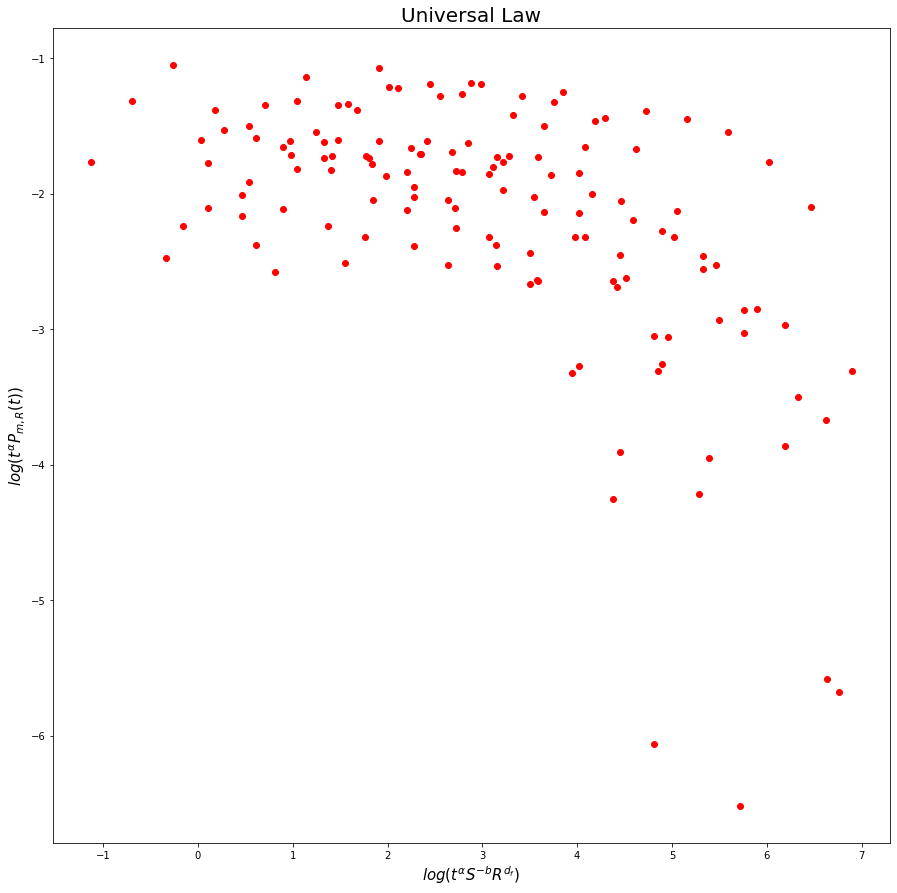

In [39]:
fig0, axt = plt.subplots(figsize=(15,15))

b=G[0][1]
Yt1=alphau*np.log10(Xu)+np.log10(Yu)
Xt1=np.log10(Xu)+b*mu + dfu*np.log10(Ru)  -4

#alfac=1
#dsfc=1
#Yt2=alfac*np.log10(Xu)+np.log10(Yu)
#Xt2=np.log10(Xu)+b*mu + dfu*np.log10(Ru)  -4

axt.scatter(Xt1,Yt1,color='red')
axt.set_title('Universal Law',size=20)
axt.set_xlabel('$log(t^{\\alpha}S^{-b}R^{d_{f}})$',size=15)
axt.set_ylabel('$log(t^{\\alpha}P_{m,R}(t))$',size=15);

In [9]:
mu

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2.])

In [ ]:
Cu